In [1]:
%load_ext tensorboard

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import numpy as np

train_df = pd.read_pickle("../data/train_cens.pkl.gz")
train_df.head()

,name,parent,cens_slice,index
0,XC109605,acafly,"[[0.3086012466109237, 0.30568218743577036, 0.3...","(25, 75)"
0,XC109605,acafly,"[[0.37812375487169103, 0.3725999263434882, 0.3...","(157, 207)"
0,XC109605,acafly,"[[0.38193222855739883, 0.3810666924182529, 0.3...","(260, 310)"
0,XC109605,acafly,"[[0.3523993330368658, 0.3480284909351147, 0.34...","(324, 374)"
0,XC109605,acafly,"[[0.3179275282653602, 0.3194400852268083, 0.32...","(361, 411)"


In [3]:
import tensorflow as tf

def reshape_square(arr, k=8):
    """Domain specific. Transform 12x50 matrix into a square matrix that's 25x25."""
    x = np.zeros((12, k*k))
    x[:, :arr.shape[1]] = arr
    return x.reshape(3, 2*k, 2*k).T
    
X = np.stack(train_df.cens_slice.apply(reshape_square))

lb = LabelBinarizer()
lb.fit(train_df.parent)
y = lb.transform(train_df.parent)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [4]:
# https://github.com/tensorpack/tensorpack/blob/5845ead80e3d77c89e2f1e9d5e0691324a8354cc/examples/ResNet/cifar10-preact18-mixup.py#L101-L118

def _mixup(x_in, y_in):
    n = x_in.shape[0]
    # draw from uniform instead of beta(alpha, alpha, BATCH_SIZE)
    w = np.random.uniform(0.3, 0.7, size=n)
    x_weight = w.reshape(n, 1, 1, 1)
    index = np.random.permutation(n)

    x = x_in * x_weight + x_in[index] * (1-x_weight)
    y = y_in + y_in[index]
    return x, y

@tf.function(input_signature=[
    tf.TensorSpec(None, tf.float64), 
    tf.TensorSpec(None, tf.int32), 
])
def mixup(x_in, y_in):
    x, y = tf.numpy_function(_mixup, [x_in, y_in], [tf.float64, tf.int32])
    return tf.data.Dataset.from_tensor_slices((
        tf.reshape(x, [-1, 16, 16, 3]), 
        tf.reshape(y, [-1, 397])
    ))

def add_mixup(dataset, batch_size=1024):
    return (
        dataset
        .shuffle(batch_size)
        .window(batch_size)
        .flat_map(lambda x, y: tf.data.Dataset.zip((x.batch(batch_size), y.batch(batch_size))))
        .map(mixup, num_parallel_calls=tf.data.AUTOTUNE)
        .flat_map(lambda x: x)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

add_mixup(test_dataset)

<PrefetchDataset shapes: ((None, 16, 16, 3), (None, 397)), types: (tf.float64, tf.int32)>

In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Softmax, Flatten, Dense
from tensorflow_addons.metrics import F1Score

def get_compiled_model(input_shape=(16, 16, 3), output_shape=397):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(output_shape, activation='sigmoid'))
    
    model.compile(optimizer='adam',
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy', F1Score(num_classes=output_shape)])
    return model

In [6]:
model = get_compiled_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 128)         7

In [10]:
from pathlib import Path
import datetime
logdir = Path("../data/logs/") / datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

checkpoint_path = "../data/models/model-16-16-3/model"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [11]:
history = model.fit(add_mixup(train_dataset, 256), 
                    epochs=100, 
                    validation_data=test_dataset.batch(256),
                    callbacks=[cp_callback, tensorboard_callback])

Epoch 1/100
1725/1725 [==============================] - 30s 18ms/step - loss: 0.0296 - accuracy: 0.0346 - f1_score: 0.0092 - val_loss: 0.0168 - val_accuracy: 0.0431 - val_f1_score: 0.0120

Epoch 00001: saving model to ../data/models/model-16-16-3\model
Epoch 2/100
1725/1725 [==============================] - 28s 16ms/step - loss: 0.0295 - accuracy: 0.0360 - f1_score: 0.0112 - val_loss: 0.0168 - val_accuracy: 0.0462 - val_f1_score: 0.0142

Epoch 00002: saving model to ../data/models/model-16-16-3\model
Epoch 3/100
1725/1725 [==============================] - 28s 16ms/step - loss: 0.0294 - accuracy: 0.0376 - f1_score: 0.0129 - val_loss: 0.0165 - val_accuracy: 0.0465 - val_f1_score: 0.0156

Epoch 00003: saving model to ../data/models/model-16-16-3\model
Epoch 4/100
1725/1725 [==============================] - 28s 16ms/step - loss: 0.0294 - accuracy: 0.0395 - f1_score: 0.0145 - val_loss: 0.0166 - val_accuracy: 0.0500 - val_f1_score: 0.0185

Epoch 00004: saving model to ../data/models/mode

KeyboardInterrupt: 

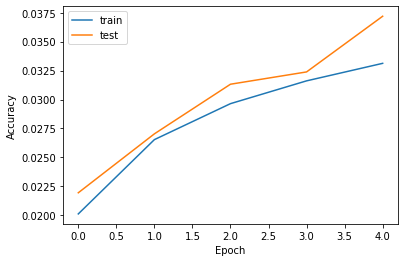

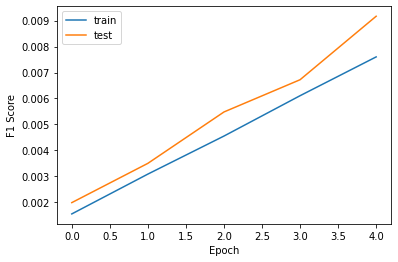

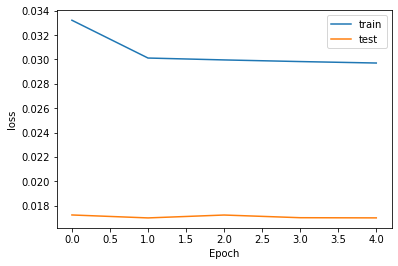

5914/5914 - 42s - loss: 0.0163 - accuracy: 0.0648 - f1_score: 0.0359


[0.01631036214530468,
 0.06476926058530807,
 array([0.        , 0.00309119, 0.11572499, 0.        , 0.00520156,
        0.003663  , 0.        , 0.        , 0.00475624, 0.09200884,
        0.        , 0.        , 0.01709402, 0.        , 0.04539007,
        0.        , 0.00884956, 0.        , 0.        , 0.        ,
        0.03245436, 0.        , 0.06666667, 0.13309735, 0.        ,
        0.01052632, 0.00828157, 0.08347826, 0.        , 0.04958677,
        0.        , 0.        , 0.03138833, 0.02586207, 0.        ,
        0.01023018, 0.01538462, 0.01222494, 0.18153118, 0.        ,
        0.05414012, 0.05584642, 0.05921052, 0.02247191, 0.        ,
        0.0648379 , 0.09406953, 0.05019305, 0.04465335, 0.12349316,
        0.00337268, 0.        , 0.01680672, 0.        , 0.17872341,
        0.03252032, 0.        , 0.05555556, 0.02890174, 0.03508772,
        0.02146341, 0.16836198, 0.02912621, 0.        , 0.04081633,
        0.04639175, 0.048583  , 0.        , 0.00787402, 0.        ,
    

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot([x.mean() for x in history.history['f1_score']], label='train')
plt.plot([x.mean() for x in history.history['val_f1_score']], label='test')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

model.evaluate(X_test, y_test, verbose=2)

In [13]:
checkpoint_path = "../data/models/model-16-16-3-no-mixup/model"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit(train_dataset.batch(256),
                    epochs=20, 
                    validation_data=test_dataset.batch(256),
                    callbacks=[cp_callback, tensorboard_callback])

Epoch 1/20
1725/1725 [==============================] - 33s 19ms/step - loss: 0.0149 - accuracy: 0.0945 - f1_score: 0.0662 - val_loss: 0.0151 - val_accuracy: 0.0846 - val_f1_score: 0.0572

Epoch 00001: saving model to ../data/models/model-16-16-3-no-mixup\model
Epoch 2/20
1725/1725 [==============================] - 33s 19ms/step - loss: 0.0147 - accuracy: 0.1040 - f1_score: 0.0772 - val_loss: 0.0151 - val_accuracy: 0.0868 - val_f1_score: 0.0603

Epoch 00002: saving model to ../data/models/model-16-16-3-no-mixup\model
Epoch 3/20
1725/1725 [==============================] - 33s 19ms/step - loss: 0.0145 - accuracy: 0.1120 - f1_score: 0.0867 - val_loss: 0.0151 - val_accuracy: 0.0879 - val_f1_score: 0.0628

Epoch 00003: saving model to ../data/models/model-16-16-3-no-mixup\model
Epoch 4/20
1725/1725 [==============================] - 34s 20ms/step - loss: 0.0144 - accuracy: 0.1183 - f1_score: 0.0947 - val_loss: 0.0152 - val_accuracy: 0.0875 - val_f1_score: 0.0630

Epoch 00004: saving model

In [17]:
model.save("../data/models/model-16-16-3-no-mixup-full")

INFO:tensorflow:Assets written to: ../data/models/model-16-16-3-no-mixup-full\assets


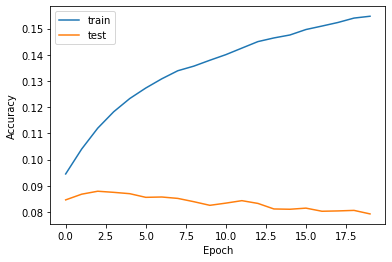

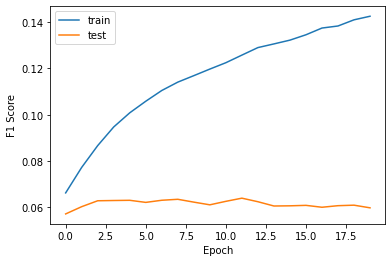

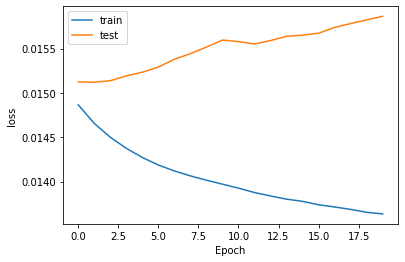

5914/5914 - 47s - loss: 0.0159 - accuracy: 0.0793 - f1_score: 0.0598


[0.01586400903761387,
 0.0792534351348877,
 array([0.0466563 , 0.0292887 , 0.12583669, 0.        , 0.04974397,
        0.01692525, 0.        , 0.        , 0.05212356, 0.1556064 ,
        0.        , 0.04469274, 0.04206619, 0.03514377, 0.06222222,
        0.00657895, 0.09859154, 0.        , 0.00798403, 0.03612904,
        0.0546697 , 0.00498753, 0.08430913, 0.18211032, 0.02839756,
        0.02870813, 0.0323741 , 0.08895949, 0.02205882, 0.07761732,
        0.        , 0.02079002, 0.05997693, 0.06792453, 0.02006689,
        0.0562249 , 0.07045291, 0.03036437, 0.21904762, 0.01136364,
        0.06589786, 0.12054121, 0.08695652, 0.04166666, 0.        ,
        0.05387206, 0.06829268, 0.0493421 , 0.04977778, 0.15484634,
        0.03241491, 0.01335559, 0.01574803, 0.        , 0.10181818,
        0.06709957, 0.03947369, 0.09356726, 0.05038335, 0.06470589,
        0.05482718, 0.22535211, 0.01777778, 0.        , 0.05286343,
        0.05723906, 0.08274232, 0.        , 0.03376019, 0.00740741,
     

In [15]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot([x.mean() for x in history.history['f1_score']], label='train')
plt.plot([x.mean() for x in history.history['val_f1_score']], label='test')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

model.evaluate(X_test, y_test, verbose=2)